In [40]:
import tonic.datasets as datasets
import tonic.transforms as transforms
from snn_delays.config import DATASET_PATH
import numpy as np
import torch

PATH = DATASET_PATH

### event transform: downsample
downsample = transforms.Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None)

### frame transforms
frame_transform = transforms.ToFrame(sensor_size=(17, 17, 2), n_time_bins=50,  overlap=0)
target_transform = transforms.ToOneHotEncoding(n_classes=10)

## events from test set of n-mnist
nmnist = datasets.NMNIST(save_to=PATH, train=False, first_saccade_only=True)

# get indexes per class
class_indices = {}
for idx, (_, label) in enumerate(nmnist):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# how many samples per class from 0-9
for x in range(10):
    print(len(class_indices[x]))


980
1135
1032
1010
982
892
958
1028
974
1009


### Downsample events and convert to frames

In [41]:
from torch.utils.data import Subset, DataLoader, TensorDataset

class_indices = dict(sorted(class_indices.items()))

### 10 indexes, one for each class, are picked randomly
sampled_indices = [np.random.choice(indices) for indices in class_indices.values()]

### uncomment if you want to save the whole test dataset (10000 samples)
### sampled_indices = [*range(10000)]

frames = torch.zeros(len(sampled_indices), 50, 2, 17, 17) 
onehot_labels = torch.zeros(len(sampled_indices), 10)

downsampled_events = []

import torch
for i, idx in enumerate(sampled_indices):
    raw_events, raw_label = nmnist[idx]
    downsampled_events.append(downsample(raw_events))
    frames[i] = torch.from_numpy(frame_transform(downsampled_events[-1]))
    onehot_labels[i] = torch.from_numpy(target_transform(raw_label))

### Save downsampled events

Each element of downsampled_events is a Tuple (list_of_events, class), where each event in list_of_events is Tuple (x, y, timestamp, polarity)

In [42]:
downsampled_events[7]

array([(11, 13,   414, 1), ( 5, 16,  2039, 1), ( 6,  5,  2611, 0), ...,
       ( 9,  8, 95320, 1), ( 8,  6, 97593, 0), (10,  7, 98769, 0)],
      dtype=[('x', '<i4'), ('y', '<i4'), ('t', '<i4'), ('p', '<i4')])

In [43]:
# some stats
for events in downsampled_events:
    print(f'{len(events)} events from {events[0][2]} to {events[-1][2]} us')

2032 events from 912 to 99678 us
346 events from 2339 to 98943 us
2089 events from 597 to 99955 us
824 events from 5835 to 99998 us
972 events from 1149 to 99895 us
1619 events from 1454 to 99921 us
2055 events from 738 to 99930 us
1604 events from 414 to 98769 us
1823 events from 1920 to 99730 us
1012 events from 1782 to 99955 us


In [44]:
# save
np.savez('events.npz', *downsampled_events)

In [45]:
#load
file = np.load('events.npz')

# check file keys 
print(file.keys())

# display the array corresponding to number 7
print(file['arr_7'])

KeysView(NpzFile 'events.npz' with keys: arr_0, arr_1, arr_2, arr_3, arr_4...)
[(11, 13,   414, 1) ( 5, 16,  2039, 1) ( 6,  5,  2611, 0) ...
 ( 9,  8, 95320, 1) ( 8,  6, 97593, 0) (10,  7, 98769, 0)]


### Create dataset from frames

In [46]:
import torch
print(frames.shape)
print(onehot_labels.shape)
dataset = TensorDataset(frames, onehot_labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

torch.Size([10, 50, 2, 17, 17])
torch.Size([10, 10])


### Inference from frames

In [47]:
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.visualization_utils import plot_param
from snn_delays.snn import SNN
import matplotlib.pyplot as plt

model_name = 'binary_nmnist50_l1_1d1.t7_9232_max_56epoch'
ckpt_dir = 'exp_snn2chip_nmnist'
snn = ModelLoader(model_name, ckpt_dir, 10, 'cuda', True)
snn.total_time = snn.win

aa, bb = snn.test(dataloader, only_one_batch=True)



[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
None
1
Delta t: 0.02 ms
mean of normal: 6.907255237315501
Instance of <class 'snn_delays.experimental_models.snn_binary.BinarySNN'> loaded successfully
Test Loss: 0.10529270023107529
Avg spk_count per neuron for all 50 time-steps 19.15156364440918
Avg spk per neuron per layer [19.1515625]
Test Accuracy of the model on the test samples: 100.000



### 2D Visualization of inputs (sum across 50 timesteps and 2 channels)

torch.Size([10, 50, 2, 17, 17])
torch.Size([10, 17, 17])


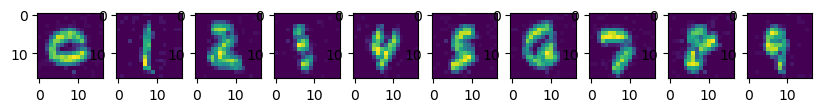

In [48]:
img_frames = torch.sum(frames, dim=(1, 2))
print(frames.shape)
print(img_frames.shape)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(img_frames[i, :, :])

### Per-layer visualizations

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5, 1.0, 'first layer spikes')

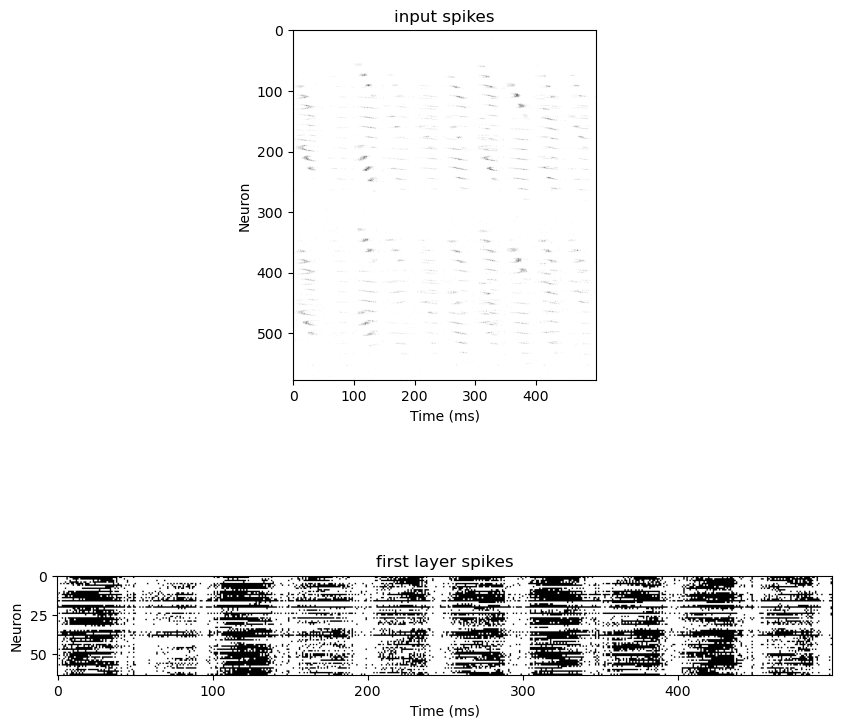

In [49]:
from snn_delays.utils.visualization_utils import plot_raster
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('input spikes')
plot_raster(snn, 'input', 10)
plt.subplot(212)
plot_raster(snn, 'f1', 10)
plt.title('first layer spikes')

Text(0.5, 1.0, 'membrane potentials')

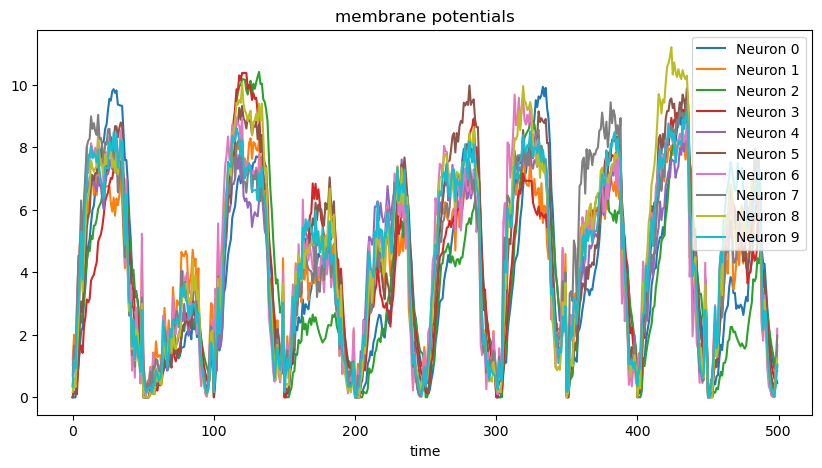

In [50]:
mem_output = snn.mem_state['output']
mems_out = mem_output[:, :10, :].permute(1, 0, 2).reshape(500, 10)
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(mems_out.cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('membrane potentials')

Text(0.5, 1.0, 'softmax of membrane potentials')

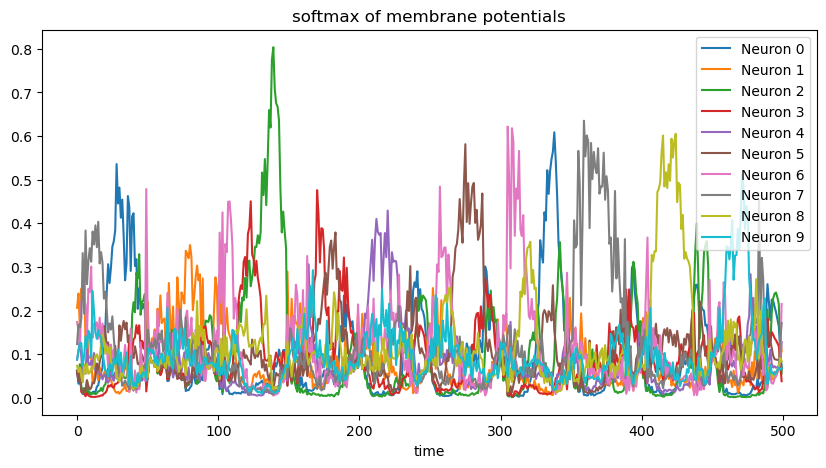

In [51]:
import torch.nn.functional as F
soft_mems = F.softmax(snn.mem_state['output'][:, :10, :], dim=2).permute(1, 0, 2).reshape(500, 10)
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems.detach().cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
    plt.legend()
plt.xlabel('time')
plt.title('softmax of membrane potentials')

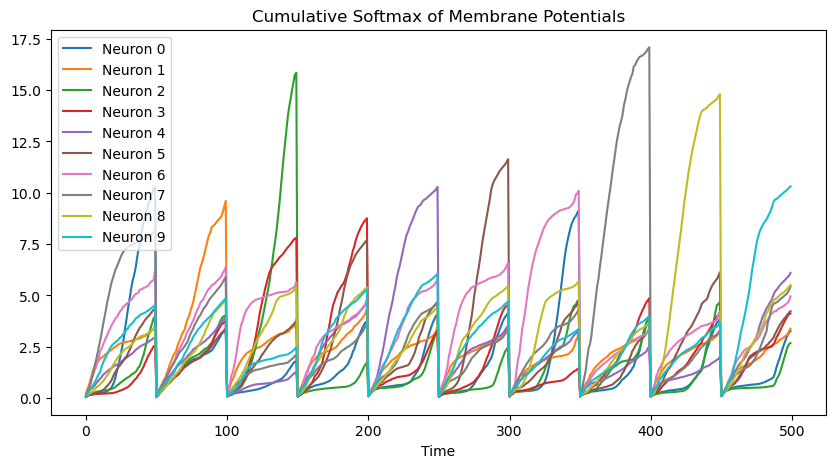

In [52]:
# Apply softmax to the first 10 neurons' membrane potentials
soft_mems = F.softmax(snn.mem_state['output'][:, :10, :], dim=2)
soft_mems_cumulative = torch.cumsum(soft_mems, dim=0)
soft_mems_cumulative = soft_mems_cumulative.permute(1, 0, 2).reshape(500, 10)

# Plot the cumulative softmax membrane potentials
plt.figure(figsize=(10, 5))
for neuron in range(10):
    plt.plot(soft_mems_cumulative.detach().cpu().numpy()[:, neuron], label=f'Neuron {neuron}')
plt.legend()
plt.xlabel('Time')
plt.title('Cumulative Softmax of Membrane Potentials')
plt.show()

Winner neuron behaves as expected, from 0 to 9 :)